# Tutorial II: Custom Filters

The dpEmu package provides many filters for common use cases, but it might occur that no built-in filter exists for what you want. To solve this problem, you can create your own filters by inheriting the `Filter`-template. In this tutorial, we will create a custom filter for converting input images from RGB to grayscale.

First, let's generate some input data. We'll use numpy's `randomstate` with a set seed to ensure repeatability. The `randomstate` object simply replaces the `np.random`-part of any function call you want to make to numpy's random module.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.RandomState(seed=0)
img = rand.randint(low=0, high=255, size=(20, 20, 3))
data = np.array([img for _ in range(9)])

Let's see what these random images look like:

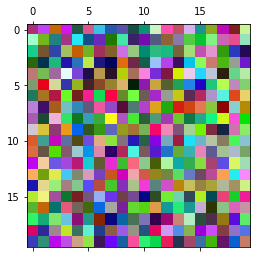

In [2]:
plt.matshow(data[0])

Before we write our own filter, let's rehearse what we learned in the previous tutorial and try modifying the image with an existing filter. We'll use the Resolution filter here.

In [3]:
from dpemu.nodes import Array, Series
from dpemu.filters.image import Resolution

image_node = Array()
series_node = Series(image_node)
resolution_filter = Resolution("scale")
image_node.addfilter(resolution_filter)

params = {"scale" : 2}
errorified = series_node.generate_error(data, params)

Let's quickly check that the output is what we'd expect:

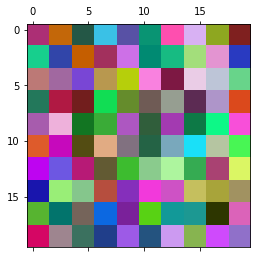

In [4]:
plt.matshow(errorified[0])

Now we're ready to write our own filter to replace the built-in resolution filter. To do this, we want to inherit the `Filter`-class in `dpemu.filters.filter`. When we inherit the class, we'll want to define a constructor and override the `apply`-function which applies the filter to the input data. The first parameter of the function is the input data. In this case we do not need the other two parameters, but we'll learn how to use them later on in this tutorial.

In [6]:
from dpemu.filters.filter import Filter

class Grayscale(Filter):
    def __init__(self):
        super().__init__()
    def apply(self, node_data, random_state, named_dims):
        avg = np.sum(node_data, axis=-1) // 3
        for ci in range(3):
            node_data[:, :, ci] = avg

The code here is very simple. In the apply-function, we just take the mean of the color channels, and then assign that to each of them. Note that Filters must always maintain the dimensions of the input data. That is why the processed image will still contain 3 color channels, despite being in grayscale.

Let's try our filter. Unlike before, we do not pass any parameters when calling `generate_error`, since or filter doesn't take any parameters.

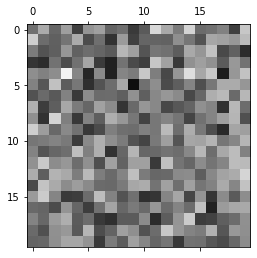

In [8]:
image_node = Array()
series_node = Series(image_node)
grayscale_filter = Grayscale()
image_node.addfilter(grayscale_filter)

params = {}
errorified = series_node.generate_error(data, params)

plt.matshow(errorified[0])

Now that we understand how a simple filter works, let's incorporate randomness and parameters. We'll change the filter so that every pixel gets replaced with its grayscale equivalent with some probability given as a parameter:

In [7]:
class RandomGrayscale(Filter):
    def __init__(self, probability_id):
        super().__init__()
        self.probability_id = probability_id
    def apply(self, node_data, random_state, named_dims):
        inds = random_state.rand(node_data.shape[0], node_data.shape[1]) < self.probability
        avg = np.sum(node_data[inds], axis=-1) // 3
        for ci in range(3):
            node_data[inds, ci] = avg

If you read the code carefully, you might notice that `self.probability` is not defined anywhere. For convenience, for every variable ending in `_id`, a value will be assigned to the variable without the `_id`-suffix from the params-list passed to `generate_error`. For example, if we have variable `probability_id`, which is set to `"probability"` in the initializer, and we call `generate_error` with a dictionary containing the key-value pair `"probability" : 0.5`, the value of `self.probability` will be `0.5`.

In function `__init__`, we take the identifier for our probability parameter. This will be used as the key to find the value of `self.probability` from the params-dictionary.

In apply, we randomize the positions where the pixel will be replaced by its grayscale equivalent, then replace them as we did previously. For repeatability, we use the numpy `RandomState` passed to the function as the second parameter.

Let's inspect the results:

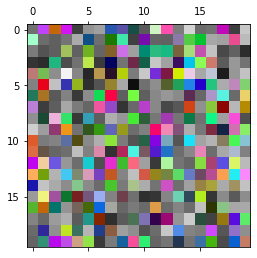

In [8]:
image_node = Array()
series_node = Series(image_node)
grayscale_filter = RandomGrayscale("probability")
image_node.addfilter(grayscale_filter)

params = {"probability" : 0.5}
errorified = series_node.generate_error(data, params)

plt.matshow(errorified[0])

Now, the only thing we are yet to understand is the `named_dims` parameter to `apply`. For this, imagine our tuple of ten images is a video. We'll create a filter that makes the pixels in the video decay into grayscale over time. Once a pixel turns grayscale, it won't turn back, and by expectation half of the pixels will decay in the amount of frames given as a parameter.

Most of the new code is just randomizing the times at which individual pixels decay. Note that we make a copy of the random_state to ensure that we generate the same times for every image in the series. This is to ensure pixels don't gain back their colors after decaying.

In [10]:
from math import log
from copy import deepcopy

class DecayGrayscale(Filter):
    def __init__(self, half_time_id):
        super().__init__()
        self.half_time_id = half_time_id
    def apply(self, node_data, random_state, named_dims):
        shape = (node_data.shape[0], node_data.shape[1])
        times = deepcopy(random_state).exponential(scale=(self.half_time / log(2)), size=shape)
        inds = times <= named_dims["time"]
        avg = np.sum(node_data[inds], axis=-1) // 3
        for ci in range(3):
            node_data[inds, ci] = avg

We use `named_dims` on the line `inds = times <= named_dims["time"]`. This line creates a mask of all pixels that decay before the current time, which is given by `named_dims["time"]`. To use this filter, we'll have to tell the series-node that the dimension it is iterating over is called "time":

In [13]:
image_node = Array()
series_node = Series(image_node, "time")
grayscale_filter = DecayGrayscale("half_time")
image_node.addfilter(grayscale_filter)

params = {"half_time" : 2}
errorified = series_node.generate_error(data, params)

Finally, to show multiple images in the same plot, we'll have to do some more work:

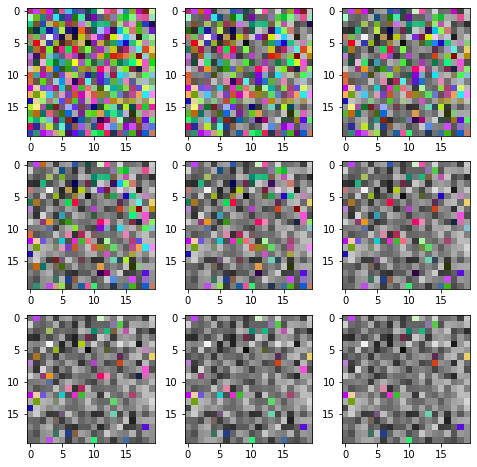

In [14]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 9 + 1):
    fig.add_subplot(3, 3, i)
    plt.imshow(errorified[i-1])
plt.show()

And we have achieved the desired effect! This concludes the second tutorial.

The notebook for this tutorial can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/tutorials/Custom_Filters.ipynb).